# Extracting Vega Lite Transformations

In this notebook, I will show some use cases for extracting out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in a Vega Lite spec and moving their computation to the MapD database from the client. 

To demonstrate this functionality, we recreate the examples the Vega Lite team used to demonstrate this feature: https://vega.github.io/vega-lite-transforms2sql/


## Install

First, we have to install the `omnisci_renderer` package, as well as altair, ibis and the MapD client. We need to install a development branch of ibis until https://github.com/ibis-project/ibis/pull/1675 is released.

In [1]:
!pip install git+https://github.com/ibis-project/ibis.git

  Cloning https://github.com/ibis-project/ibis.git to /private/var/folders/m7/t8dvwtnn32z84333p845tly40000gn/T/pip-req-build-a5qda0jm
  Running setup.py bdist_wheel for ibis-framework ... done
  Stored in directory: /private/var/folders/m7/t8dvwtnn32z84333p845tly40000gn/T/pip-ephem-wheel-cache-grv15zgn/wheels/8a/c2/88/670715f4de52a624752c7c364644312d026f810996015bf09e
Successfully built ibis-framework


In [1]:
import altair as alt
import ibis
import omnisci_renderer

## Carrier names

Let's recreate the first example, counting the carrier names.

First we connect to thte table using Ibis:

In [2]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)
t = conn.table("flights_donotmodify")

Then we compose an Altair chart using an ibis expression.

In [3]:
c = alt.Chart(t[t.carrier_name]).mark_bar().encode(
    x='carrier_name',
    y='count()'
)

Finally, we enable rendering that extracts the aggregate expressions and adds them onto the Ibis expresion:

/usr/local/miniconda3/envs/jupyterlab-omnisci/lib/python3.6/site-packages/altair/utils/core.py:86: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


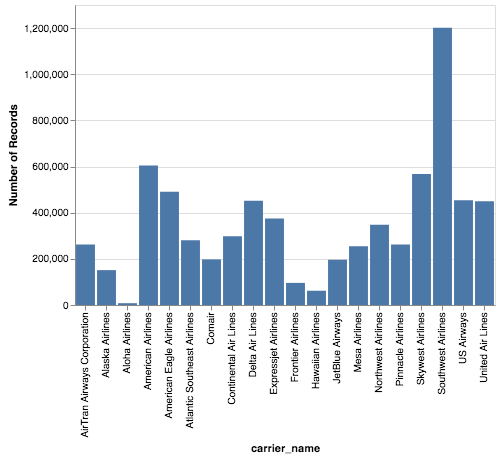

In [4]:
alt.data_transformers.enable('ibis')
alt.renderers.enable("extract-ibis")
c

## Delay by Month

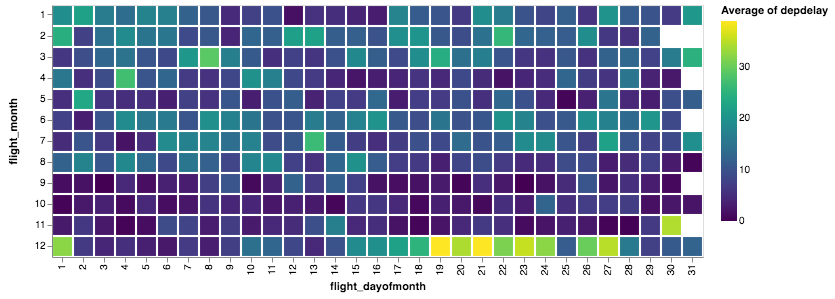

In [5]:
delay_by_month = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(
    x='flight_dayofmonth:O',
    y='flight_month:O',
    color='average(depdelay)'
)
delay_by_month

## Debugging

We can use `display_chart` to show some intermediate computatitons for the chart. It does this by enabling different Altair renderers and displaying the chart:

In [6]:
??omnisci_renderer.display_chart

Signature: omnisci_renderer.display_chart(chart)
Docstring: <no docstring>
Source:   
def display_chart(chart):
    display(Code('alt.renderers.enable("json")'))
    alt.renderers.enable("json")
    display(chart)

    display(Code('alt.renderers.enable("extract-json")'))
    alt.renderers.enable("extract-json")
    chart._repr_mimebundle_(None, None)

    display(Code('alt.renderers.enable("extract-ibis-sql")'))
    alt.renderers.enable("extract-ibis-sql")
    chart._repr_mimebundle_(None, None)

    display(Code('alt.renderers.enable("extract-ibis")'))
    alt.renderers.enable("extract-ibis")
    chart._repr_mimebundle_(None, None)
File:      ~/p/mapd/notebooks/jupyterlab-omnisci/omnisci_renderer.py
Type:      function


alt.renderers.enable("json")

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


alt.renderers.enable("extract-json")

<IPython.core.display.JSON object>

alt.renderers.enable("extract-ibis-sql")

SELECT "carrier_name", count(*) AS "count_*"
FROM (
  SELECT "carrier_name"
  FROM flights_donotmodify
) t0
GROUP BY carrier_name

alt.renderers.enable("extract-ibis")

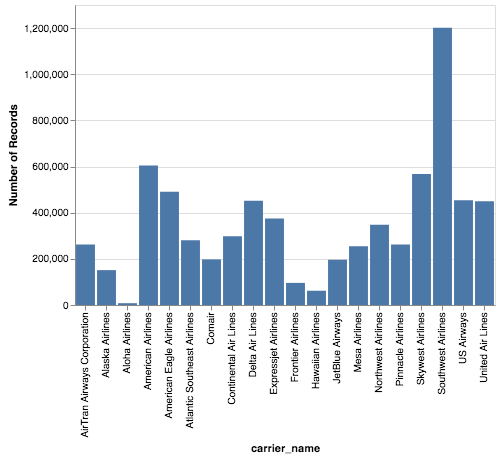

In [7]:
omnisci_renderer.display_chart(c)

alt.renderers.enable("json")

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


alt.renderers.enable("extract-json")

<IPython.core.display.JSON object>

alt.renderers.enable("extract-ibis-sql")

SELECT "flight_dayofmonth", "flight_month",
       avg("depdelay") AS average_depdelay
FROM (
  SELECT "flight_dayofmonth", "flight_month", "depdelay"
  FROM flights_donotmodify
) t0
GROUP BY flight_dayofmonth, flight_month

alt.renderers.enable("extract-ibis")

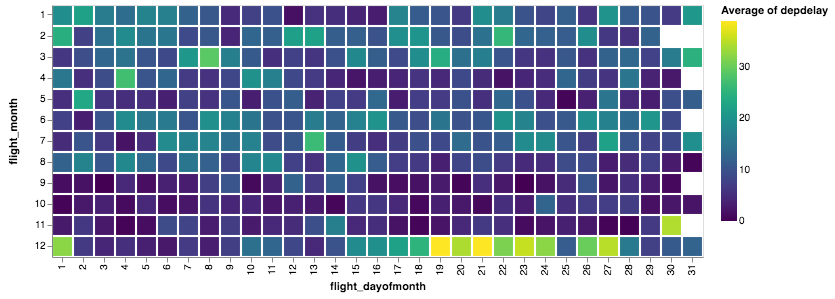

In [8]:
omnisci_renderer.display_chart(delay_by_month)